In [41]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import os 
import timeit

% matplotlib inline

In [2]:
def load_data(dataset = 'gibbs-sample.dat.npy', borrow = True):
    """
    Loads the dataset.
    """
    data = np.load(dataset)
    dataset = theano.shared(np.asarray(data, dtype = theano.config.floatX), borrow = borrow)
        
    return dataset   

In [17]:
class mpf(object):
    """
    Minimum probability flow
    """
    
    def __init__(self, input = None, n = 16, W = None, b = None):
        """
        Initialize mpf class
        """
        self.n = n
        
        U = np.random.rand(self.n, self.n)
        R = 0.5 * (U + U.T)
        np.fill_diagonal(R, 0)
        
        if not W:
            initial_W = np.asarray(R, dtype = theano.config.floatX)
            W = theano.shared(initial_W, name = 'W', borrow = True)
        
        if not b:
            b = theano.shared(np.zeros(n, dtype = theano.config.floatX), name = 'b', borrow = True)
            
            
        self.W = W
        self.b = b
#         self.input = input
        if input is None:
            self.x = T.dmatrix(name = 'input')
        else:
            self.x = input
        
        self.params = [self.W, self.b]
    
    
    def Kcost(self, epsilon = 0.01, learning_rate = 0.01):
        """
        Returns the cost
        """
        
        cost = T.mean(T.exp((0.5 - self.x) * (T.dot(self.x, self.W) + self.b))) * epsilon
#         gparams = T.grad(cost, self.params)
#         updates = [(param, param - learning_rate * gparam) for param, gparam in zip(self.params, gparams)]
        Wgrad = T.grad(cost, self.W)
        bgrad = T.grad(cost, self.b)
        
        Wupdate = T.fill_diagonal(0.5 * ((self.W - learning_rate * Wgrad) + (self.W - learning_rate * Wgrad).T), 0)
#         Wupdate = 0.5 * ((self.W - learning_rate * Wgrad) + (self.W - learning_rate * Wgrad).T)
        updates = [(self.W, Wupdate), (self.b, self.b - learning_rate * bgrad )]
        
        return cost, updates
            
                

In [33]:
def sgd(learning_rate = 0.01, n_epochs = 50, dataset = 'gibbs-sample.dat.npy', batch_size = 50, output_folder = 'mpf_results'):
    """
    Perform stochastic gradient descent on MPF
    """
    print ('Loading '+dataset+'...')
    
    dataset = load_data(dataset)
    
    n_dataset_batches = dataset.get_value(borrow = True).shape[0] // batch_size
    
    print ('Building the model...')

    index = T.lscalar()
    x = T.matrix('x')
    
#     if not os.path.isdir(output_folder):
#         os.makedirs(output_folder)
#     os.chdir(output_folder)   
    
    flow = mpf(input = x)
    cost, updates = flow.Kcost()
    
    train_mpf = theano.function(inputs = [index], outputs = cost, updates = updates, \
                                givens = {x: dataset[index * batch_size: (index + 1) * batch_size]})
    
    start_time = timeit.default_timer()
    
    for epoch in range(n_epochs):
        c = []
        for batch_index in range(n_dataset_batches):
            c.append(train_mpf(batch_index))

        print ('Training epoch %d, cost' % epoch, np.mean(c, dtype='float64'))
        
    end_time = timeit.default_timer()
    
    training_time = end_time - start_time
    
    print ('The training took %.2f seconds' % (training_time/60.))
    
    W_learnt = flow.W.get_value(borrow = True)
    W = np.load('W.dat.npy')
    

In [34]:
sgd()

Loading gibbs-sample.dat.npy...
Building the model...
Training epoch 0, cost 0.0291873373308
Training epoch 1, cost 0.025873087703
Training epoch 2, cost 0.0233691767179
Training epoch 3, cost 0.0214008229233
Training epoch 4, cost 0.0198064709116
Training epoch 5, cost 0.0184845788269
Training epoch 6, cost 0.0173679305598
Training epoch 7, cost 0.0164101492803
Training epoch 8, cost 0.0155781323812
Training epoch 9, cost 0.0148475740767
Training epoch 10, cost 0.0142001950224
Training epoch 11, cost 0.0136219627405
Training epoch 12, cost 0.0131019113119
Training epoch 13, cost 0.0126313365564
Training epoch 14, cost 0.0122032338085
Training epoch 15, cost 0.0118118966983
Training epoch 16, cost 0.011452625355
Training epoch 17, cost 0.0111215105649
Training epoch 18, cost 0.0108152716627
Training epoch 19, cost 0.0105311330886
Training epoch 20, cost 0.0102667292047
Training epoch 21, cost 0.0100200300576
Training epoch 22, cost 0.00978928286723
Training epoch 23, cost 0.00957296546

In [14]:
e = mpf()

In [15]:
e.n

16

In [16]:
e.W.get_value()

array([[ 0.        ,  0.39604025,  0.60089678,  0.7050529 ,  0.36098649,
         0.1134071 ,  0.63169966,  0.56936553,  0.58299608,  0.58411516,
         0.47700798,  0.70533777,  0.62870156,  0.25883978,  0.55990836,
         0.6975752 ],
       [ 0.39604025,  0.        ,  0.40957708,  0.68902985,  0.26251731,
         0.31160284,  0.45807381,  0.45322285,  0.7283745 ,  0.46826541,
         0.32045399,  0.57775205,  0.3080416 ,  0.24435734,  0.17415364,
         0.71163772],
       [ 0.60089678,  0.40957708,  0.        ,  0.44396438,  0.32221286,
         0.60306179,  0.6116395 ,  0.42132924,  0.18445616,  0.33056094,
         0.35038628,  0.37866518,  0.64922321,  0.41769249,  0.36764416,
         0.05893529],
       [ 0.7050529 ,  0.68902985,  0.44396438,  0.        ,  0.15750308,
         0.47762009,  0.51848963,  0.81434602,  0.35695929,  0.83936385,
         0.36286409,  0.57242149,  0.63534739,  0.71734609,  0.38492076,
         0.50635264],
       [ 0.36098649,  0.26251731,  0

In [ ]:
Q = np.random.rand(2,2)

In [ ]:
R = 0.5 * (Q + Q.T)

In [ ]:
np.fill_diagonal(R, 0)

In [9]:
U = np.random.rand(3, 3)
R = 0.5 * (U + U.T)
print(R)

[[ 0.49551631  0.78881879  0.58994301]
 [ 0.78881879  0.38253977  0.29270314]
 [ 0.58994301  0.29270314  0.12937292]]


In [11]:
np.fill_diagonal(R, 0)
print (R)

[[ 0.          0.78881879  0.58994301]
 [ 0.78881879  0.          0.29270314]
 [ 0.58994301  0.29270314  0.        ]]


In [37]:
W = np.load('W.dat.npy')

In [43]:
W = W.reshape(1,-1)
print (W.shape)
print (type(W))

(1, 256)
<class 'numpy.ndarray'>


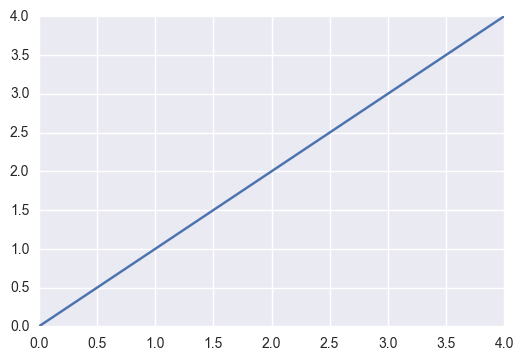

In [45]:
A = np.arange(5)
plt.plot(A)

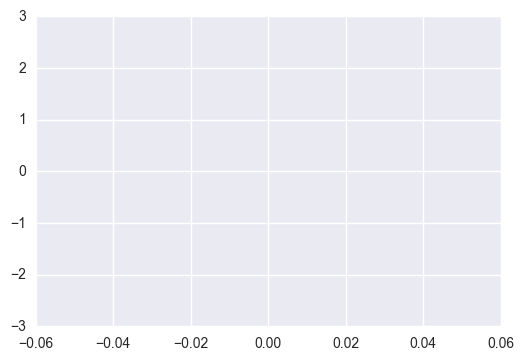

In [42]:
plt.plot(W)

In [44]:
W

array([[ 0.        ,  0.23315981, -0.41442199,  0.64734756, -1.09865496,
         0.18951477,  0.67176322, -0.50910919, -0.20054966, -0.64993808,
        -0.08537763,  0.43167974,  0.55934658,  0.0693222 ,  0.68748319,
         1.57273294,  0.23315981,  0.        , -1.64633056,  2.11321877,
         1.95552244,  1.19651397,  0.65851845,  0.21703923,  0.56161409,
         0.91434768,  0.81798816, -0.374813  , -0.94486193, -1.90613505,
         0.55496683,  0.64158013, -0.41442199, -1.64633056,  0.        ,
         1.18725173,  0.73725632,  1.67308946, -0.58135902, -0.47021966,
         0.35275579,  0.52580778, -1.01085213,  0.11835908,  0.96472162,
         0.79835586, -0.62715385,  2.17213668,  0.64734756,  2.11321877,
         1.18725173,  0.        , -0.21717797, -1.04710238, -0.06816384,
         1.41845501,  0.86562215,  1.3496813 ,  1.00354722,  0.17350864,
        -0.30145845, -0.0944941 ,  1.07682338,  0.15071019, -1.09865496,
         1.95552244,  0.73725632, -0.21717797,  0. 